# **Home Assignment: Deep Learning from Scratch**
## Daniel Kovachev and Yuval Amrami
### 315870808_316417591

In [9]:
# Install a conda package in the current Jupyter kernel
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
warnings.simplefilter("ignore")
from scipy import io
import matplotlib.pyplot as plt


# Part I: the classifier and optimizer
## Subsection I - Softmax and its gradient

For start, we will load the datasets PeaksData and GMMData to the working environment.

In [2]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')
mat2 = scipy.io.loadmat('GMMData.mat')

In [3]:
X = mat['Yt']
Y = mat['Ct']
X_val = mat['Yv']
Y_val = mat['Cv']
print(X.shape)
print(Y.shape)
X2 = mat2['Yt']
Y2 = mat2['Ct']
X2_val = mat2['Yv']
Y2_val = mat2['Cv']
print(X2.shape)
print(Y2.shape)

(2, 25000)
(5, 25000)
(5, 25000)
(5, 25000)


<br><br><br><br>We will now, define the softmax function, and its gradient with respect to the weigths, baises and data.<br>
softmax function definition is : $\frac{e^{x_i}}{\sum_j e^{x_j}}$

In [37]:
import numpy as np

class softmax:
    def gradient(self, X, Y, error, W):
        M = X.shape[1]
        grad_theta = 1/M * error @ X.T
        grad_b = 1/M * np.sum(error, axis=1)
        grad_data = 1/M * W.T @ error
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        exp = np.exp(x)
        return (exp / np.sum(exp, axis=0))

The next part of the code will define our loss function which is the cross entropy loss.<br>
We assume that the predicted data provided to this function went through a softmax function as its most recent process before applying this loss function.<br>
Cross entropy checks the diffrence between two probabilities in the following way : $\frac{1}{M}\sum(Y_{true} * log(Y_{predicted}))$ where m is the size of the dataset , and Y true is 1 hot encoded vector with size L(number of classes)

In [38]:
def cross_entropy_loss(y_true, y_predicted, epsilon=1e-10):
    predictions = np.clip(y_predicted, epsilon, 1. - epsilon)
    M = predictions.shape[1]
    return -np.sum(y_true * np.log(predictions)) / M

The class linear_layer is a wrapper around simple linear layer which will later be used as a building block to our nueral network.<br>
Linear layer consists of activation function and linear function in the form : $\sigma(AX + B)$.<br>
The function update_weigths and gradient will be later used in the SGD. Notice that the gradient function is just a wrapper around the activation layer gradient function.

In [161]:
class linear_layer:
    def __init__(self, dim_in, dim_out, activation):
        self._A = np.random.normal(.5, .5, size=(dim_out, dim_in))
        self._B = np.random.normal(.5, .5, size=(dim_out, 1))
        self._activation = activation
        self._dim_in = dim_in
        self._dim_out = dim_out
        
    def update_weigths(self, gradient_theta, gradient_b, learning_rate):
        gradient_b = gradient_b.reshape(self._dim_out, 1)
        self._A = self._A - learning_rate * gradient_theta
        self._B = self._B - learning_rate * gradient_b
    
    def gradient(self, X, Y, error):
        return self._activation.gradient(X, Y, error, self._A)
    
    
    
    def dim_in(self):
        return self._dim_in
    
    def dim_out(self):
        return self._dim_out
    
    def activate_with_weigths_change(self, d, X):
        return self._activation((self._A + d) @ X + self._B)
        
    def activate_with_biases_change(self, d, X):
        return self._activation(self._A @ X + (self._B + d))
    
    def __call__(self, X):
        return self._activation(self._A @ X + self._B)

In general the gradient test is defined as follows : we know that $|f(x + \epsilon*d) - f(x)| = O(\epsilon)$ , we want to check that $|f(x + \epsilon*d) - f(x) - \epsilon*d*grad(x)| = O(\epsilon^2)$ <br>
We can now check that our linear function with softmax activation passes the gradient test, where $f(x) = Loss(Y_{true}, Y_{predicted})$.<br>
We will start by checking the gradient with respect to the data.<br>
Notice that since we only check the gradient with respect to the data , the random vector $\epsilon * d$ is added the data in the following way $f(\sigma(W(X + \epsilon * d) + b))$

In [158]:
def create_random_vector(dim_in, dim_out):
    d = np.random.normal(.5, .5, size=(dim_out, dim_in))
    return d / np.linalg.norm(d)

def gradient_test_with_respect_to_data(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d_input = create_random_vector(dim_in, 1)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d_input
        predictions = linear_layer(X)
        predictions_d = linear_layer(X + vec)
        _, _, grad_data = linear_layer.gradient(X, Y, predictions - Y)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        with_gradient.append(np.abs(diff_f - vec.T.dot(grad_data).reshape(1)))
    return without_gradient, with_gradient

<br><br><br><br><br><br><br><br><br>
In each iteration of the gradient test we define $\epsilon = 0.5^i$ where i is the number of the current iteration. <br>
We will then draw those 2 lines in log scale, and we expect that the second formula(with the gradient) will converge faster.

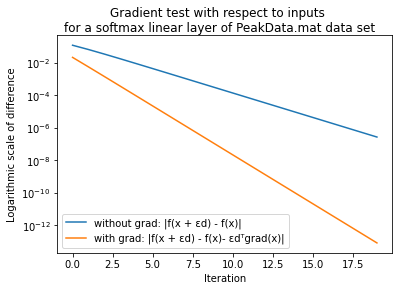

In [42]:
without_grad, with_grad = gradient_test_with_respect_to_data(
            cross_entropy_loss, linear_layer(2,5, softmax()),
             X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to inputs \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

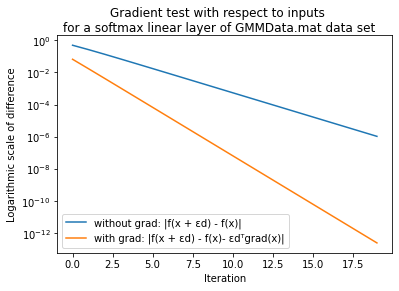

In [43]:
without_grad, with_grad = gradient_test_with_respect_to_data(
        cross_entropy_loss, linear_layer(5,5, softmax()),
            X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to inputs \nfor a softmax linear layer of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

The following code test the gradient with respect to the baises, the basic idea of the gradient test applies here as well we only need to make small modifications, we need to add the random vector $\epsilon * d$ to the baises instead of the data 
$f(\sigma(WX + (b + \epsilon * d)))$ <br>
Regarding this test we will use the gradient of the softmax function with respect to the baises.

In [44]:
def gradient_test_with_respect_to_baises(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, 1)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_biases_change(vec, X)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        _, grad_baises, _ = linear_layer.gradient(X, Y, predictions - Y)
        with_gradient.append(np.abs(diff_f - vec.T.dot(grad_baises).reshape(1)))
    return without_gradient, with_gradient

we expect the same result here as we got in the gradient test with respect to the data

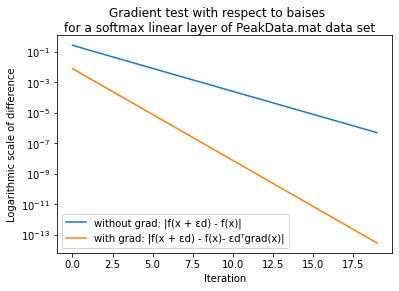

In [45]:
without_grad, with_grad = gradient_test_with_respect_to_baises(
        cross_entropy_loss, linear_layer(2,5, softmax()),
             X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to baises \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

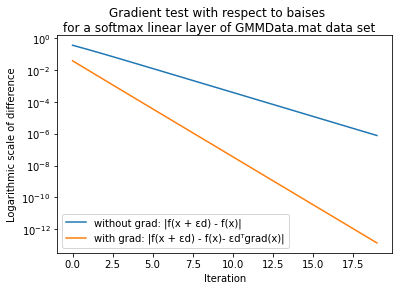

In [47]:
without_grad, with_grad = gradient_test_with_respect_to_baises(
        cross_entropy_loss, linear_layer(5,5, softmax()),
            X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to baises \nfor a softmax linear layer of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

<br><br><br><br><br><br><br><br>
now for the final test, we will test the gradient with respect to the weigths. we will now add the random vector $\epsilon * d$ to the weights as follows : $f(\sigma((W+\epsilon * d)X + b))$

In [48]:
def gradient_test_with_respect_to_weigths(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, dim_in)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_weigths_change(vec, X)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        grad_theta, _, _ = linear_layer.gradient(X, Y, predictions - Y)
        with_gradient.append(np.abs(diff_f - 
                (np.ravel(vec) @ np.ravel(grad_theta)).reshape(1)))
    return without_gradient, with_gradient

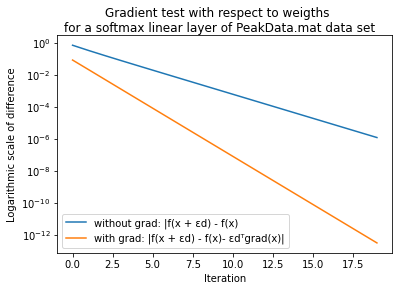

In [49]:
without_grad, with_grad = gradient_test_with_respect_to_weigths(
    cross_entropy_loss, linear_layer(2,5, softmax()),
         X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to weigths \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

<br><br><br><br>

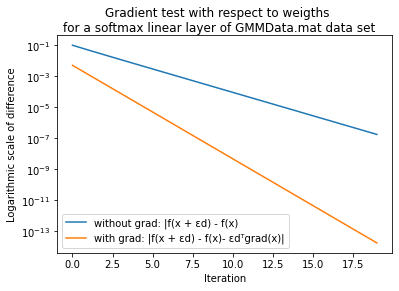

In [50]:
without_grad, with_grad = gradient_test_with_respect_to_weigths(
    cross_entropy_loss, linear_layer(5,5, softmax()),
         X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to weigths \nfor a softmax linear layer of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

As we can see, the test result shows a relation of square values between the subtraction results with and without the gradient for all three tests and for both data sets as expected.<br>
we can clearly see that our linear_layer passes the gradient test and we can move on to the second part, which is writing the SGD.

<br><br><br><br><br><br><br><br><br><br><br><br><br>
## Subsection II - SGD
Before we start writing the SGD, we will define the class sequential_model which is just a wrapper over some linear_layers, and will help calculting the output of the model and the total gradient.<br>
Note that this class also saves the outputs after each layer to be later used in the gradient function.

In [51]:
class sequential_model:
    def __init__(self, *layers):
        self._layers = []
        self._history = []
        last_dim_out = 0
        for layer in layers:
            if last_dim_out != 0 and last_dim_out != layer.dim_in():
                print('dimension dont match layer out dim {} , next layer dim in {}'.
                      format(last_dim_out, layer.dim_in()))
                raise 
            self._layers.append(layer)
            last_dim_out = layer.dim_out()

    def gradient(self, Y_true):
        gradient = []
        error = self._history[-1] - Y_true
        for i in range(1, len(self._layers) + 1):
            X = self._history[-i - 1]
            Y = self._history[-i]
            gradient_theta, gradient_b, error = self._layers[-i].gradient(X, Y, error)
            gradient.append((gradient_theta, gradient_b, error))
        return gradient
    
    def __call__(self, X):
        new_X = np.array(X, copy=True) 
        self._history = []
        self._history.append(new_X)
        for layer in self._layers:
            new_X = layer(new_X)
            self._history.append(new_X)
        return new_X

    def layers(self):
        return self._layers

The accuracy function is defined as follows : $ \frac{argmax(Y_{true}) = argmax(Y_{predicted})}{size} $

In [52]:
def accuracy(Y_true, Y_predicted):
    return np.sum(np.argmax(Y_true, axis=0) 
                  == np.argmax(Y_predicted, axis=0)) / Y_true.shape[1]

Now we will define out SGD , this function receive the model as input and in each epoch , it update the weigths based on the gradient. Then it calculate the accuracy the and the loss for the train set and the validation set.<br>
Importent thing to note is that each layer updates its own weights according to the gradient calculated up to this point.
<br><br><br>

In [53]:
import math

def update_weigths(model, learning_rate, Y_true):
    grad = model.gradient(Y_true)
    for i, (gradient_theta, gradient_b, error) in enumerate(reversed(grad)):
        model.layers()[i].update_weigths(gradient_theta, gradient_b, learning_rate)


def SGD(model, X, Y, X_val, Y_val, epoch, learning_rate, loss, batch_size):
    accuracy_train = []
    accuracy_val = []
    loss_train = []
    loss_val = []
    number_of_iterations = math.ceil(X.shape[1] / batch_size)
    for i in range(epoch):
        iter_accuracy = 0
        iter_loss = 0
        for j in range(0, X.shape[1], batch_size):
            Y_predicted = model(X[:, j:j+batch_size])
            update_weigths(model, learning_rate, Y[:, j:j+batch_size])
            iter_accuracy += accuracy(Y[:, j:j+batch_size], Y_predicted)
            iter_loss += loss(Y[:, j:j+batch_size], Y_predicted)
        Y_predicted_val = model(X_val)
        accuracy_train.append(iter_accuracy / number_of_iterations)
        loss_train.append(iter_loss / number_of_iterations)
        accuracy_val.append(accuracy(Y_val, Y_predicted_val))
        loss_val.append(cross_entropy_loss(Y_val, Y_predicted_val))
    return loss_train, accuracy_train, loss_val, accuracy_val

We will now check that the SGD minimize the objective function.

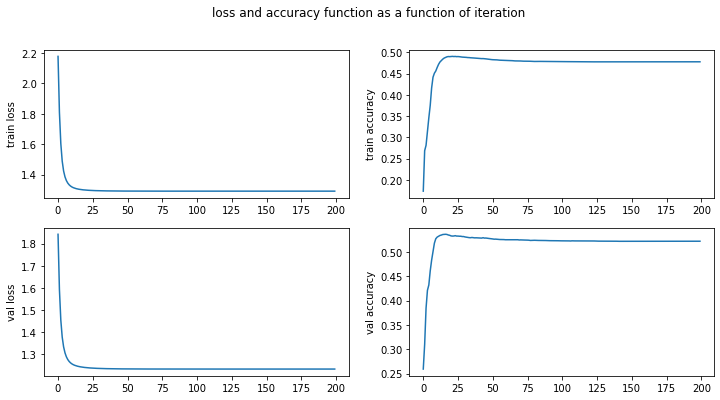

In [55]:
import matplotlib.pyplot as plt

model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X, Y, X_val, Y_val,
                                                200, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

And now for the GMM dataset.

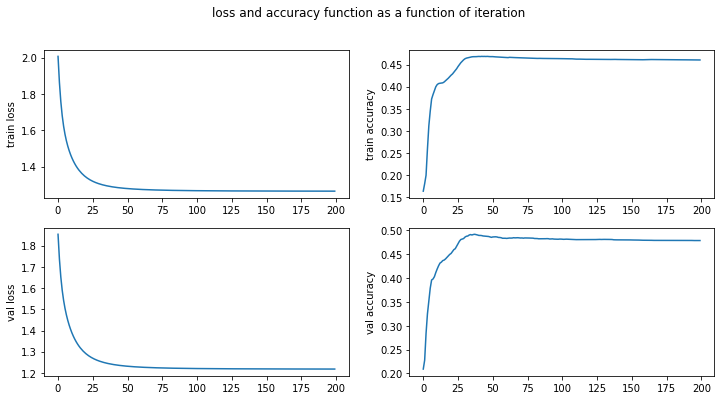

In [57]:
model = sequential_model(
        linear_layer(5, 5, activation=softmax())
        )

train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X2, Y2, X2_val, Y2_val,
                                                    200, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

The SGD works as expected , but we see that the loss converges which probably means that we need to pick new hyper parameters or the model isn't expressive enought.<br>
In the next section we will see how to choose the right hypter parameters using a grid search.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
## Subsection III - SGD Hyper Parameters

In order to find the best parameters for the learning process, we will define a grid search function. Given some hyper paramters lists, the function will activate different combinations and will demonstrate the result, allowing us to find the best one.

In [179]:
def grid_search(model_init, X, Y, X_val, Y_val, 
                learning_rate_values, iteration_values, batch_size_values):
    train_accuracy = []
    val_accuracy = []
    val_loss = []
    train_loss = []
    for learning_rate in learning_rate_values:
        for iteration_num in iteration_values:
            for batch_size in batch_size_values:
                model = model_init()
                loss_train, accuracy_train, loss_val, accuracy_val = SGD(model,
                                X, Y, X_val, Y_val, iteration_num, learning_rate,
                                cross_entropy_loss, batch_size)
                train_accuracy.append(accuracy_train)
                val_accuracy.append(accuracy_val)
                train_loss.append(loss_train)
                val_loss.append(loss_val)
    return train_accuracy, train_loss, val_accuracy, val_loss

We will now test our grid function and plot the best results, according to the best validation accuracy.

In [180]:
learning_rates = [0.2, 0.1, 0.05, 0.01, 0.001]
iteration_values = [10, 20, 50, 100, 200]
batch_sizes = [50, 100, 500, 1000, 2500]

train_accuracy, train_loss, val_accuracy, val_loss = 
    grid_search(lambda : sequential_model(linear_layer(2, 5, activation=softmax())),
                X, Y, X_val, Y_val, learning_rates, iteration_values, batch_sizes)

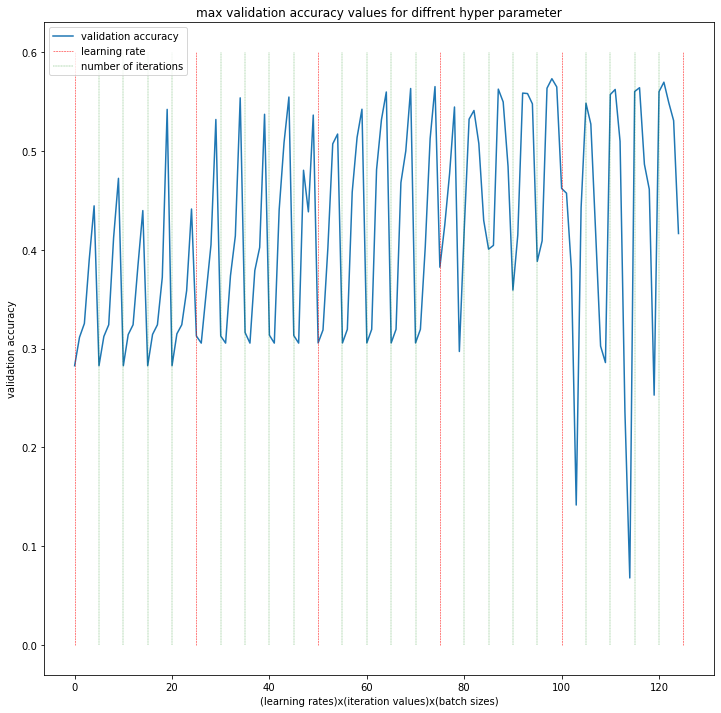

In [181]:
max_values = list(map(lambda x : max(x), val_accuracy))

plt.figure(figsize=(12,12))
plt.plot(max_values)
plt.title("max validation accuracy values for diffrent hyper parameter")
plt.ylabel('validation accuracy')
plt.xlabel('(learning rates)x(iteration values)x(batch sizes)')
plt.plot([25, 25], [0, 0.6], 'r--', lw=0.5, label="iteration values")
a = plt.plot([5, 5], [0, 0.6], 'g--', lw=0.3, label="number of iterations")
plt.plot([50, 50], [0, 0.6], 'r--', lw=0.5,)
plt.plot([75, 75], [0, 0.6], 'r--', lw=0.5,)
plt.plot([100, 100], [0, 0.6], 'r--', lw=0.5,)
plt.plot([0, 0], [0, 0.6], 'r--', lw=0.5,)
plt.plot([125, 125], [0, 0.6], 'r--', lw=0.5,)
plt.plot([10, 10], [0, 0.6], 'g--', lw=0.3,)
plt.plot([15, 15], [0, 0.6], 'g--', lw=0.3,)
plt.plot([20, 20], [0, 0.6], 'g--', lw=0.3,)
plt.plot([30, 30], [0, 0.6], 'g--', lw=0.3,)
plt.plot([35, 35], [0, 0.6], 'g--', lw=0.3,)
plt.plot([40, 40], [0, 0.6], 'g--', lw=0.3,)
plt.plot([45, 45], [0, 0.6], 'g--', lw=0.3,)
plt.plot([55, 55], [0, 0.6], 'g--', lw=0.3,)
plt.plot([60, 60], [0, 0.6], 'g--', lw=0.3,)
plt.plot([65, 65], [0, 0.6], 'g--', lw=0.3,)
plt.plot([70, 70], [0, 0.6], 'g--', lw=0.3,)
plt.plot([80, 80], [0, 0.6], 'g--', lw=0.3,)
plt.plot([85, 85], [0, 0.6], 'g--', lw=0.3,)
plt.plot([90, 90], [0, 0.6], 'g--', lw=0.3,)
plt.plot([95, 95], [0, 0.6], 'g--', lw=0.3,)
plt.plot([105, 105], [0, 0.6], 'g--', lw=0.3,)
plt.plot([110, 110], [0, 0.6], 'g--', lw=0.3,)
plt.plot([115, 115], [0, 0.6], 'g--', lw=0.3,)
plt.plot([120, 120], [0, 0.6], 'g--', lw=0.3)

plt.legend(['validation accuracy', 'learning rate', 'number of iterations'], 
           loc='upper left')

plt.show()

<br><br> In the next plot we will show the max validation accuracy as function of batch sizes for fixed learning rates.

batch sizes are 50, 100, 500, 1000, 25000


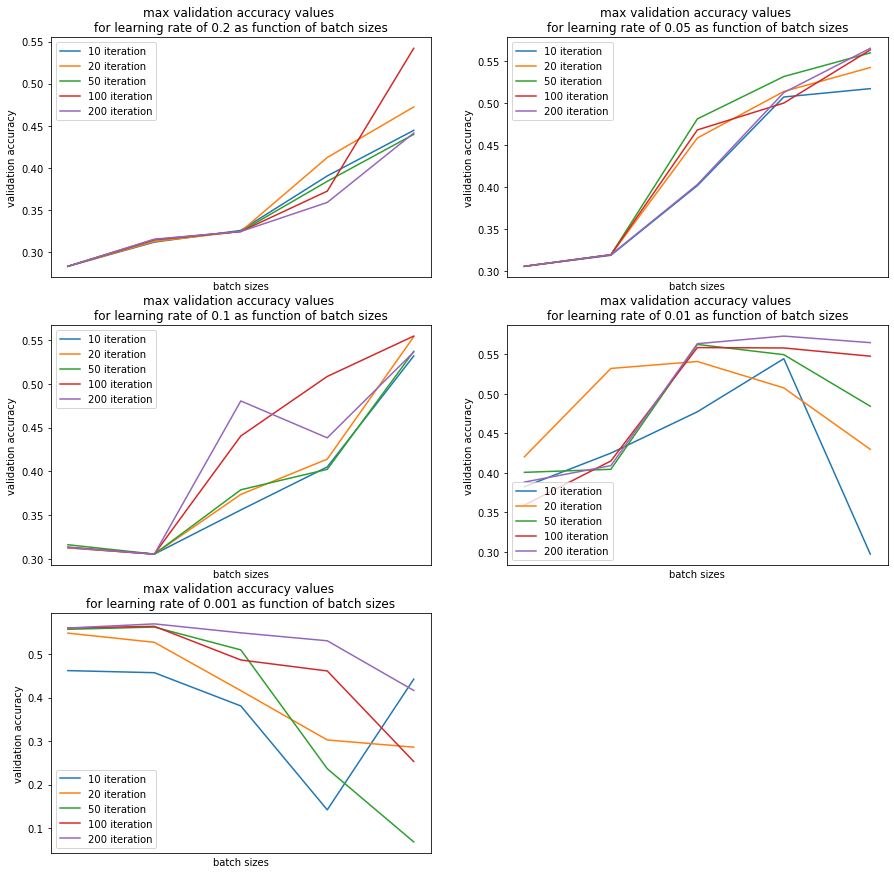

In [182]:
max_values = list(map(lambda x : max(x), val_accuracy))

batch_sizes_1 ,batch_sizes_2, batch_sizes_3 ,batch_sizes_4, 
    batch_sizes_5 = [],[],[],[],[]

batch_sizes_1B , batch_sizes_2B , batch_sizes_3B ,batch_sizes_4B, 
    batch_sizes_5B =  [],[],[],[],[]

batch_sizes_1C ,batch_sizes_2C ,batch_sizes_3C ,batch_sizes_4C, 
    batch_sizes_5C =  [],[],[],[],[]

batch_sizes_1D, batch_sizes_2D ,batch_sizes_3D ,batch_sizes_4D , 
    batch_sizes_5D =  [],[],[],[],[]

batch_sizes_1E ,batch_sizes_2E ,batch_sizes_3E ,batch_sizes_4E , 
    batch_sizes_5E =  [],[],[],[],[]

for i in range(5):
    batch_sizes_1.append(max_values[i])
    batch_sizes_2.append(max_values[i+5])
    batch_sizes_3.append(max_values[i+10]) 
    batch_sizes_4.append(max_values[i+15])
    batch_sizes_5.append(max_values[i+20])
    batch_sizes_1B.append(max_values[i+25])
    batch_sizes_2B.append(max_values[i+5+25])
    batch_sizes_3B.append(max_values[i+10+25]) 
    batch_sizes_4B.append(max_values[i+15+25])
    batch_sizes_5B.append(max_values[i+20+25])
    batch_sizes_1C.append(max_values[i+50])
    batch_sizes_2C.append(max_values[i+5+50])
    batch_sizes_3C.append(max_values[i+10+50]) 
    batch_sizes_4C.append(max_values[i+15+50])
    batch_sizes_5C.append(max_values[i+20+50])
    batch_sizes_1D.append(max_values[i+75])
    batch_sizes_2D.append(max_values[i+5+75])
    batch_sizes_3D.append(max_values[i+10+75]) 
    batch_sizes_4D.append(max_values[i+15+75])
    batch_sizes_5D.append(max_values[i+20+75])
    batch_sizes_1E.append(max_values[i+100])
    batch_sizes_2E.append(max_values[i+5+100])
    batch_sizes_3E.append(max_values[i+10+100]) 
    batch_sizes_4E.append(max_values[i+15+100])
    batch_sizes_5E.append(max_values[i+20+100])


print('batch sizes are 50, 100, 500, 1000, 25000')
fig, axs = plt.subplots(3,2, figsize=(15,15))
plt.title("max validation accuracy values for diffrent hyper parameter")

axs[0][0].plot(batch_sizes_1)
axs[0][0].plot(batch_sizes_2)
axs[0][0].plot(batch_sizes_3)
axs[0][0].plot(batch_sizes_4)
axs[0][0].plot(batch_sizes_5)
axs[0][0].set_ylabel('validation accuracy')
axs[0][0].set_xlabel('batch sizes')
axs[0][0].set_title("max validation accuracy values \nfor learning rate of 0.2 as function of batch sizes")
axs[0][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][0].set_xticks([])


axs[1][0].plot(batch_sizes_1B)
axs[1][0].plot(batch_sizes_2B)
axs[1][0].plot(batch_sizes_3B)
axs[1][0].plot(batch_sizes_4B)
axs[1][0].plot(batch_sizes_5B)
axs[1][0].set_ylabel('validation accuracy')
axs[1][0].set_xlabel('batch sizes')
axs[1][0].set_title("max validation accuracy values \nfor learning rate of 0.1 as function of batch sizes")
axs[1][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[1][0].set_xticks([])


axs[0][1].plot(batch_sizes_1C)
axs[0][1].plot(batch_sizes_2C)
axs[0][1].plot(batch_sizes_3C)
axs[0][1].plot(batch_sizes_4C)
axs[0][1].plot(batch_sizes_5C)
axs[0][1].set_ylabel('validation accuracy')
axs[0][1].set_xlabel('batch sizes')
axs[0][1].set_title("max validation accuracy values \nfor learning rate of 0.05 as function of batch sizes")
axs[0][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][1].set_xticks([])


axs[1][1].plot(batch_sizes_1D)
axs[1][1].plot(batch_sizes_2D)
axs[1][1].plot(batch_sizes_3D)
axs[1][1].plot(batch_sizes_4D)
axs[1][1].plot(batch_sizes_5D)
axs[1][1].set_ylabel('validation accuracy')
axs[1][1].set_xlabel('batch sizes')
axs[1][1].set_title("max validation accuracy values \nfor learning rate of 0.01 as function of batch sizes")
axs[1][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')
axs[1][1].set_xticks([])


axs[2][0].plot(batch_sizes_1E)
axs[2][0].plot(batch_sizes_2E)
axs[2][0].plot(batch_sizes_3E)
axs[2][0].plot(batch_sizes_4E)
axs[2][0].plot(batch_sizes_5E)
axs[2][0].set_title("max validation accuracy values \nfor learning rate of 0.001 as function of batch sizes")
axs[2][0].set_ylabel('validation accuracy')
axs[2][0].set_xlabel('batch sizes')
axs[2][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')
axs[2][0].set_xticks([])

axs[2][1].set_visible(False)


plt.ylabel('validation accuracy')


plt.show()

We can see that there is correlation between the batch size and the learning rate, for bigger learning rates we need bigger batch size and for smaller ones we need smaller batch sizes.<br>
We can also see that when using 1 layers, the number of iterations doesnt metter that much, the model converages after very small number of iterations.<br>
We can also see that using big batch size yields the best results in our dataset, we will know verify that from the grid search results and outputs the graphs of the best model.
<br><br><br><br><br><br><br><br><br><br>

the best val accuracy is obtained using learning rate = 0.01, number of iterations = 200, batch size = 1000
best accuracy : 0.57312


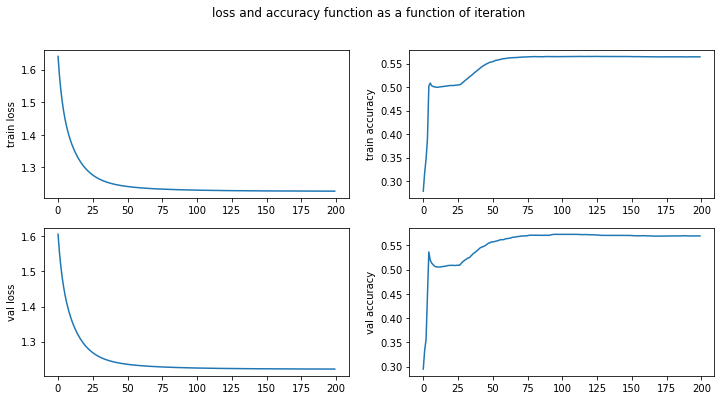

In [183]:
index = np.argmax(max_values)

print('the best val accuracy is obtained using learning rate = {}, number of iterations = {}, batch size = {}'.
      format(learning_rates[int(index / 25)], iteration_values[int(index / 5) % 5]
             , batch_sizes[index % 5]))
print('best accuracy : {}'.format(np.max(max_values)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

Just like we saw in the graphs earlier, the best results are when using learning rate 0.01 and batch size 1000. We can see that the chosen number of iterations is 200 although the model reached his higest accuracy just after ~30 iterations.<br>
We will repeat that process for the GMM data.<br><br><br><br><br>

In [186]:
train_accuracy, train_loss, val_accuracy, val_loss = grid_search(
    lambda : sequential_model(linear_layer(5, 5, activation=softmax())),
            X2, Y2, X2_val, Y2_val, learning_rates, iteration_values, batch_sizes)

batch sizes are 50, 100, 500, 1000, 25000


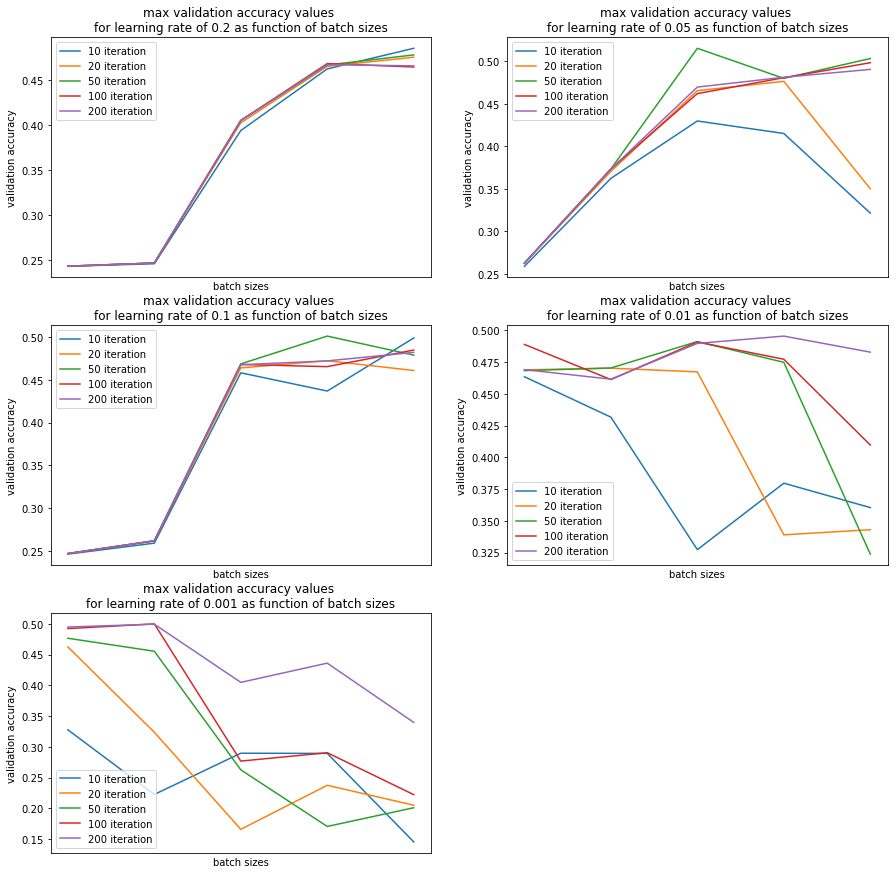

In [187]:
max_values = list(map(lambda x : max(x), val_accuracy))

batch_sizes_1 ,batch_sizes_2, batch_sizes_3 ,batch_sizes_4 , 
    batch_sizes_5 = [],[],[],[],[]

batch_sizes_1B , batch_sizes_2B , batch_sizes_3B ,batch_sizes_4B, 
    batch_sizes_5B =  [],[],[],[],[]

batch_sizes_1C ,batch_sizes_2C ,batch_sizes_3C ,batch_sizes_4C, 
    batch_sizes_5C =  [],[],[],[],[]

batch_sizes_1D, batch_sizes_2D ,batch_sizes_3D ,batch_sizes_4D , 
    batch_sizes_5D =  [],[],[],[],[]

batch_sizes_1E ,batch_sizes_2E ,batch_sizes_3E ,batch_sizes_4E , 
    batch_sizes_5E =  [],[],[],[],[]

for i in range(5):
    batch_sizes_1.append(max_values[i])
    batch_sizes_2.append(max_values[i+5])
    batch_sizes_3.append(max_values[i+10]) 
    batch_sizes_4.append(max_values[i+15])
    batch_sizes_5.append(max_values[i+20])
    batch_sizes_1B.append(max_values[i+25])
    batch_sizes_2B.append(max_values[i+5+25])
    batch_sizes_3B.append(max_values[i+10+25]) 
    batch_sizes_4B.append(max_values[i+15+25])
    batch_sizes_5B.append(max_values[i+20+25])
    batch_sizes_1C.append(max_values[i+50])
    batch_sizes_2C.append(max_values[i+5+50])
    batch_sizes_3C.append(max_values[i+10+50]) 
    batch_sizes_4C.append(max_values[i+15+50])
    batch_sizes_5C.append(max_values[i+20+50])
    batch_sizes_1D.append(max_values[i+75])
    batch_sizes_2D.append(max_values[i+5+75])
    batch_sizes_3D.append(max_values[i+10+75]) 
    batch_sizes_4D.append(max_values[i+15+75])
    batch_sizes_5D.append(max_values[i+20+75])
    batch_sizes_1E.append(max_values[i+100])
    batch_sizes_2E.append(max_values[i+5+100])
    batch_sizes_3E.append(max_values[i+10+100]) 
    batch_sizes_4E.append(max_values[i+15+100])
    batch_sizes_5E.append(max_values[i+20+100])


print('batch sizes are 50, 100, 500, 1000, 25000')
fig, axs = plt.subplots(3,2, figsize=(15,15))
plt.title("max validation accuracy values for diffrent hyper parameter")

axs[0][0].plot(batch_sizes_1)
axs[0][0].plot(batch_sizes_2)
axs[0][0].plot(batch_sizes_3)
axs[0][0].plot(batch_sizes_4)
axs[0][0].plot(batch_sizes_5)
axs[0][0].set_ylabel('validation accuracy')
axs[0][0].set_xlabel('batch sizes')
axs[0][0].set_title("max validation accuracy values \nfor learning rate of 0.2 as function of batch sizes")
axs[0][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][0].set_xticks([])


axs[1][0].plot(batch_sizes_1B)
axs[1][0].plot(batch_sizes_2B)
axs[1][0].plot(batch_sizes_3B)
axs[1][0].plot(batch_sizes_4B)
axs[1][0].plot(batch_sizes_5B)
axs[1][0].set_ylabel('validation accuracy')
axs[1][0].set_xlabel('batch sizes')
axs[1][0].set_title("max validation accuracy values \nfor learning rate of 0.1 as function of batch sizes")
axs[1][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[1][0].set_xticks([])


axs[0][1].plot(batch_sizes_1C)
axs[0][1].plot(batch_sizes_2C)
axs[0][1].plot(batch_sizes_3C)
axs[0][1].plot(batch_sizes_4C)
axs[0][1].plot(batch_sizes_5C)
axs[0][1].set_ylabel('validation accuracy')
axs[0][1].set_xlabel('batch sizes')
axs[0][1].set_title("max validation accuracy values \nfor learning rate of 0.05 as function of batch sizes")
axs[0][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][1].set_xticks([])


axs[1][1].plot(batch_sizes_1D)
axs[1][1].plot(batch_sizes_2D)
axs[1][1].plot(batch_sizes_3D)
axs[1][1].plot(batch_sizes_4D)
axs[1][1].plot(batch_sizes_5D)
axs[1][1].set_ylabel('validation accuracy')
axs[1][1].set_xlabel('batch sizes')
axs[1][1].set_title("max validation accuracy values \nfor learning rate of 0.01 as function of batch sizes")
axs[1][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')
axs[1][1].set_xticks([])


axs[2][0].plot(batch_sizes_1E)
axs[2][0].plot(batch_sizes_2E)
axs[2][0].plot(batch_sizes_3E)
axs[2][0].plot(batch_sizes_4E)
axs[2][0].plot(batch_sizes_5E)
axs[2][0].set_title("max validation accuracy values \nfor learning rate of 0.001 as function of batch sizes")
axs[2][0].set_ylabel('validation accuracy')
axs[2][0].set_xlabel('batch sizes')
axs[2][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')
axs[2][0].set_xticks([])


axs[2][1].set_visible(False)
plt.show()


Just like before, we can notice that the best results are obtained when using the large learning rate and batch size.<br>
We will now plot the results of the best model.<br><br><br><br><br><br><br><br><br><br><br><br><br>

the best val accuracy is obtained using learning rate = 0.05, number of iterations = 50, batch size = 500
best accuracy : 0.51536


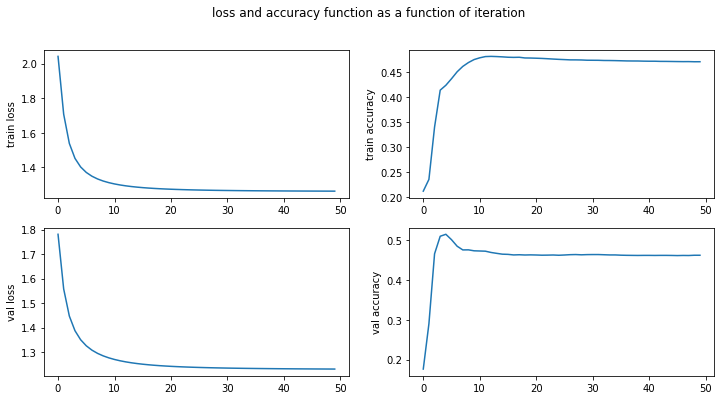

In [189]:
max_values = list(map(lambda x : max(x), val_accuracy))
index = np.argmax(max_values)

print('the best val accuracy is obtained using learning rate = {}, number of iterations = {}, batch size = {}'.
      format(learning_rates[int(index / 25)], iteration_values[int(index / 5) % 5],
        batch_sizes[index % 5]))
print('best accuracy : {}'.format(np.max(max_values)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

In conclusion, we saw that the best hyper parameters are diffrent for each dataset , as expected.<br>
We saw how to pick the right hyper parameters using grid search, this method is very time consuming but it's completly automated, so we can "just run it and go do somthing else".<br>
Since our models reached very low accuracy, we now know that those models arn't expressive enought and we need to add more layers.<br> In the next section we will define a complete NN and test it to see that our derivatives are correct.
<br>

# Part II: the neural network
## Subsection I : Jacobian Tests

The following code defines the tanh activation function and it's Jacobian with respect to the biases, weights and data.

In [73]:
class tanh:
    def gradient(self, X, Y, error, W):
        new_error = (1 - Y**2) * error
        grad_theta = new_error @ X.T 
        grad_b = np.sum(new_error, axis=1)
        grad_data = W.T @ new_error
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        return np.tanh(x)

We will now define the Jacobian test of a linear layer with tanh activation, the diffrence between the gradient test and the Jacobian test is that the function we are checking is a vector function and not scalar.<br>
The direct Jacobian transposed test for $f(x) = tanh(AX + B)$ is defined as follows, we will define new function $g(x) = f(x)^Tu$ where u is a random vector in the size of the output of f(x).<br>
Now after we have the definition of g(x) we can again use the gradient test as we did in the first section, the only diffrence is the derevitive of g(x) is now $J^Tu$ where J is the Jacobian matrix.<br>
The derivative of tanh is defined as follows : $tanh(x)' = (1 - tanh(x)^2)$<br>
The Jacobian transpose u with respect to the inputs is defined as : $J^Tu = W^T(\sigma'(WX + b) \odot u) = W^T((1 - tanh(WX + b)^2) \odot u)$.<br>
Since we are going to start with the test with respect to the inputs we need to add the random vector $\epsilon * d$ to our X.<br>

In [74]:
def g(linear_layer, x, u):
    return (linear_layer(x).T @ u).reshape(1)

def Jacobian_test_with_respect_to_inputs(linear_layer, X):
    without_Jacobian = []
    with_Jacobian = []
    dim_out = linear_layer.dim_out()
    dim_in = linear_layer.dim_in()
    d = create_random_vector(dim_in, 1)
    u = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = g(linear_layer, X, u)
        predictions_d = g(linear_layer, X + vec, u)
        _, _, jacob_txv = linear_layer.gradient(X, linear_layer(X), u)
        diff_f = predictions_d - predictions
        without_Jacobian.append(np.abs(diff_f))
        with_Jacobian.append(np.abs(diff_f - vec.T.dot(jacob_txv).reshape(1)))
    return without_Jacobian, with_Jacobian

<br>

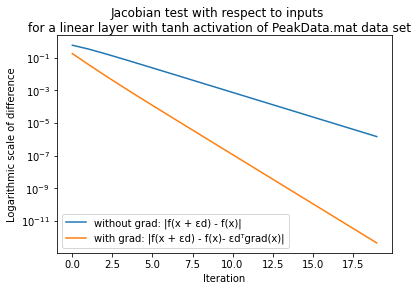

In [77]:
without_Jacobian, with_Jacobian = Jacobian_test_with_respect_to_inputs(
    linear_layer(2,5, tanh()), X[:, 0].reshape(2,1))

plt.suptitle('Jacobian test with respect to inputs \nfor a linear layer with tanh activation of PeakData.mat data set')
plt.plot(without_Jacobian, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_Jacobian, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

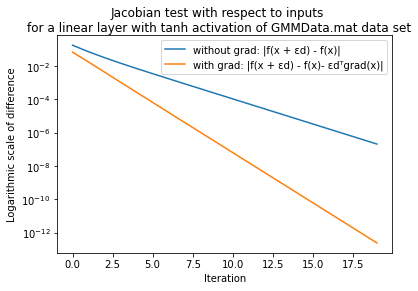

In [78]:
without_Jacobian, with_Jacobian = Jacobian_test_with_respect_to_inputs(
    linear_layer(5,5, tanh()), X2[:, 0].reshape(5,1))

plt.suptitle('Jacobian test with respect to inputs \nfor a linear layer with tanh activation of GMMData.mat data set')
plt.plot(without_Jacobian, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_Jacobian, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

The jacobian test with respect to the weigths is defined in the same way as the last test , the only thing we need to change is $ f(x) = \sigma((W + d)X + b) $ where d is a random vector with the same size as W and again we need to use the jacobian matrix with respect to the weigths.<br>
The jacobian transpose u is with respect to the weigths is defined as : $ J^Tu = (\sigma'(WX + b) \odot u)X^T = ((1 - tanh(WX + b)^2) \odot u)X^T $

In [80]:
def g(linear_layer, x, d, u):
    return linear_layer.activate_with_weigths_change(d, x), 
        (linear_layer.activate_with_weigths_change(d, x).T @ u).reshape(1)

def jacobian_test_with_respect_to_weigths(linear_layer, X):
    without_jacobian = []
    with_jacobian = []
    dim_out = linear_layer.dim_out()
    dim_in = linear_layer.dim_in()
    d = create_random_vector(dim_out, dim_in)
    u = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        Y, predictions = g(linear_layer, X, 0, u)
        _, predictions_d = g(linear_layer, X, vec, u)
        jacob_twu, _, _ = linear_layer.gradient(X, Y, u)
        diff_f = predictions_d - predictions
        without_jacobian.append(np.abs(diff_f))
        with_jacobian.append(np.abs(diff_f - 
                        (np.ravel(vec) @ np.ravel(jacob_twu)).reshape(1)))
    return without_jacobian, with_jacobian

<br><br><br><br><br><br><br><br>

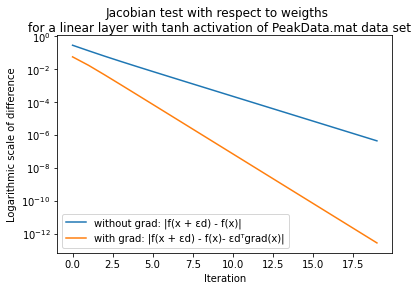

In [81]:
without_jacobian, with_jacobian = jacobian_test_with_respect_to_weigths(
            linear_layer(2,5, tanh()), X[:, 0].reshape(2,1))

plt.suptitle('Jacobian test with respect to weigths \nfor a linear layer with tanh activation of PeakData.mat data set')
plt.plot(without_jacobian, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_jacobian, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

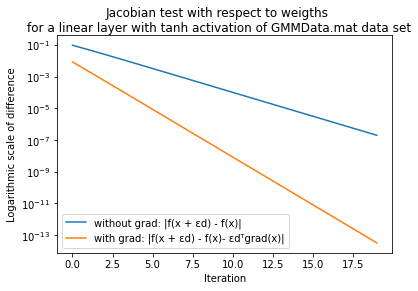

In [82]:
without_jacobian, with_jacobian = jacobian_test_with_respect_to_weigths(
            linear_layer(5,5, tanh()), X2[:, 0].reshape(5,1))

plt.suptitle('Jacobian test with respect to weigths \nfor a linear layer with tanh activation of GMMData.mat data set')
plt.plot(without_jacobian, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_jacobian, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

For the final test, the jacobian test with respect to the biases. Just like we did before we are going to add the random vector $ \epsilon * d $ to our biases and multiply it by the jacobian transpose u.<br>
The jacobian transpose u with respect to the biases is defined as : $ J^Tu = (\sigma'(WX + b) \odot u) = ((1 - tanh(WX + b)^2) \odot u) $

In [84]:
def g(linear_layer, x, d, u):
    return linear_layer.activate_with_biases_change(d, x), 
        (linear_layer.activate_with_biases_change(d, x).T @ u).reshape(1)

def jacobian_test_with_respect_to_biases(linear_layer, X):
    without_jacobian = []
    with_jacobian = []
    dim_out = linear_layer.dim_out()
    dim_in = linear_layer.dim_in()
    d = create_random_vector(dim_out, 1)
    u = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        Y, predictions = g(linear_layer, X, 0, u)
        _, predictions_d = g(linear_layer, X, vec, u)
        _, jacob_tbu, _ = linear_layer.gradient(X, Y, u)
        diff_f = predictions_d - predictions
        without_jacobian.append(np.abs(diff_f))
        with_jacobian.append(np.abs(diff_f - vec.T.dot(jacob_tbu).reshape(1)))
    return without_jacobian, with_jacobian

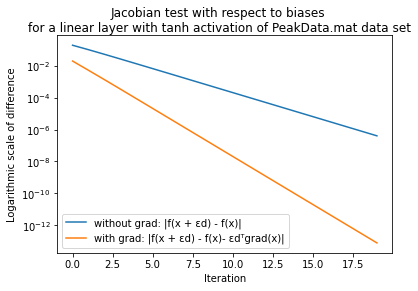

In [85]:
without_grad, with_grad = jacobian_test_with_respect_to_biases(
            linear_layer(2,5, tanh()), X[:, 0].reshape(2,1))
plt.suptitle('Jacobian test with respect to biases \nfor a linear layer with tanh activation of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

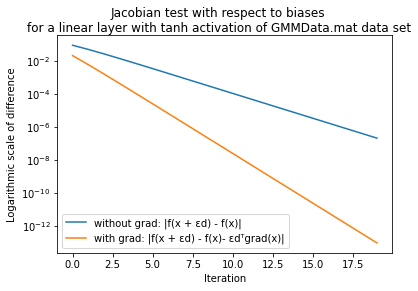

In [88]:
without_grad, with_grad = jacobian_test_with_respect_to_biases(
            linear_layer(5,5, tanh()), X2[:, 0].reshape(5,1))
plt.suptitle('Jacobian test with respect to biases \nfor a linear layer with tanh activation of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

our linear layer with tanh activation passes all the tests and now we can move on to testing the entire network gradients.

<br><br><br><br>
## Subsection II - Gradient Test For The Entire Network

In this section we will check the validity of the network as a whole model by examining the gradient test of all it's variants.<br>
We will start by testing the gradient with respect to the inputs, since we test the entire network, we need to create a list of random vectors d where each of those vector will be in the size of the input of the next layer, and then multiply all those vector with the corrospanding gradients and sum the result $ \epsilon * d * grad = \epsilon \sum_i d_i^T * grad_i $.
In order to change the input of all the layers , we will define a new function activate with matrix, which will add the vector d to all the inputs.

In [89]:
def activate_with_matrix(model, d, X):
    new_X = np.array(X, copy=True)
    for i, layer in enumerate(model.layers()):
        new_X = layer(new_X + d[i])
    return new_X

In [95]:
def model_gradient_test_with_respect_to_inputs(loss, model, X, Y):
    without_jacobian = []
    with_jacobian = []
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d_array.append(create_random_vector(layers[j].dim_in(), 1))
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        grad = list(map(lambda x : x[2], model.gradient(Y)))
        vec = list(map(lambda x: x * e, d_array))
        loss_predictions = loss(Y, predictions)
        loss_predictions_d = loss(Y, activate_with_matrix(model, vec, X))
        diff_f = loss_predictions_d - loss_predictions
        without_jacobian.append(np.abs(diff_f))
        with_jacobian.append(np.abs(diff_f - sum([vec[i - 1].T.dot(grad[-i]).
                                    reshape(1) for i in range(1, lay_len + 1)])))
    return without_jacobian, with_jacobian

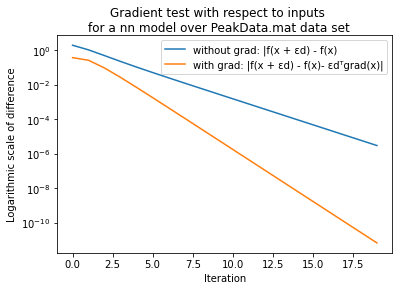

In [97]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 5, activation=softmax())
        )

without_grad, with_grad = model_gradient_test_with_respect_to_inputs(
        cross_entropy_loss, model, X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

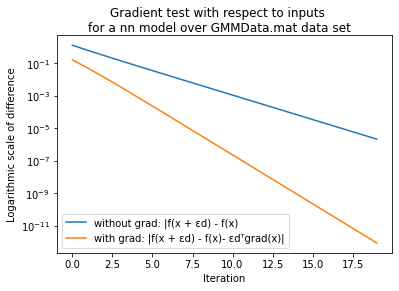

In [99]:
model2 = sequential_model(
        linear_layer(5, 5, activation=tanh()),
        linear_layer(5, 8, activation=tanh()),
        linear_layer(8, 5, activation=softmax())
        )


without_grad, with_grad = model_gradient_test_with_respect_to_inputs(
        cross_entropy_loss, model2, X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

<br><br><br>
For the gradient test with respect to the weigths, we will define the function activate_with_weigths_matrix , which will add the random vector d to the weigths of each layer before activating it just like we did with the inputs just for the weigths. the test itself is all the same, just the random vectors d will have diffrent dimension, they will be in the size of W in each layer.

In [100]:
def activate_with_weigths_matrix(model, d, X):
    new_X = np.array(X, copy=True)
    for i, layer in enumerate(model.layers()):
        new_X = layer.activate_with_weigths_change(d[i], new_X)
    return new_X

In [101]:
def model_gradient_test_with_respect_to_weigths(loss, model, X, Y):
    without_jacobian = []
    with_jacobian = []
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d_array.append(create_random_vector(layers[j].dim_out(), layers[j].dim_in()))
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        grad = list(map(lambda x : x[0], model.gradient(Y)))
        vec = list(map(lambda x: x * e, d_array))
        loss_predictions = loss(Y, predictions)
        loss_predictions_d = loss(Y, activate_with_weigths_matrix(model, vec, X))
        diff_f = loss_predictions_d - loss_predictions
        without_jacobian.append(np.abs(diff_f))
        with_jacobian.append(np.abs(diff_f - sum([(np.ravel(vec[i - 1]) @
                    np.ravel(grad[-i])).reshape(1) for i in range(1, lay_len + 1)])))
    return without_jacobian, with_jacobian

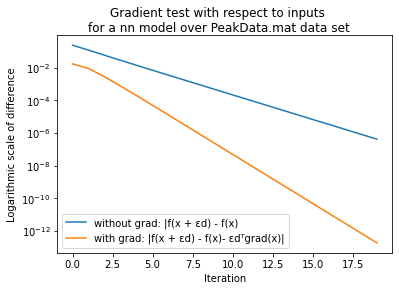

In [102]:
without_grad, with_grad = model_gradient_test_with_respect_to_weigths(
        cross_entropy_loss, model, X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

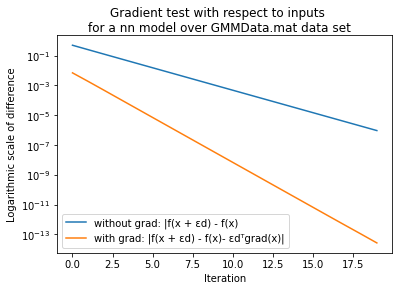

In [75]:
without_grad, with_grad = model_gradient_test_with_respect_to_weigths(
    cross_entropy_loss, model2, X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

<br><br><br><br><br><br><br>
Again we will define new function activate_with_biases_matrix, which will add the random vector d to the biases before activating the layer.

In [76]:
def activate_with_biases_matrix(model, d, X):
    new_X = np.array(X, copy=True)
    for i, layer in enumerate(model.layers()):
        new_X = layer.activate_with_biases_change(d[i], new_X)
    return new_X

In [77]:
def model_gradient_test_with_respect_to_biases(loss, model, X, Y):
    without_jacobian = []
    with_jacobian = []
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d_array.append(create_random_vector(layers[j].dim_out(), 1))
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        grad = list(map(lambda x : x[1], model.gradient(Y)))
        vec = list(map(lambda x: x * e, d_array))
        loss_predictions = loss(Y, predictions)
        loss_predictions_d = loss(Y, activate_with_biases_matrix(model, vec, X))
        diff_f = loss_predictions_d - loss_predictions
        without_jacobian.append(np.abs(diff_f))
        with_jacobian.append(np.abs(diff_f - sum([(vec[i - 1].T.dot(grad[-i])).
                                        reshape(1) for i in range(1, lay_len + 1)])))
    return without_jacobian, with_jacobian

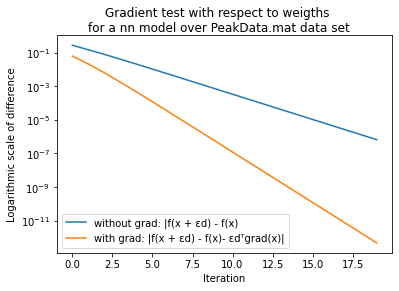

In [78]:
without_grad, with_grad = model_gradient_test_with_respect_to_biases(
        cross_entropy_loss, model, X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to weigths \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

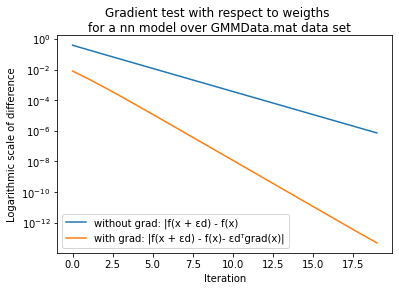

In [79]:
without_grad, with_grad = model_gradient_test_with_respect_to_biases(
        cross_entropy_loss, model2, X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to weigths \nfor a nn model over GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

As we can see our code suffice the requirement, passes the tests and can be used to train a NN.

<br><br><br><br>
# Subsection III - Training a Neural Network

In this section we try to train a neural network with multiple layers in order to achieve higher accuracy values compared to the single softmax layer.
For this end we wrote the SGD function code compatible with any model. The following code is just a toy example of what we are going to do in the next section.<br>
We will train this model which consits of 4 layers , with tanh activation and softmax in the end. In the previos section of the SGD we said that the model wasn't expresive enought beacuse he only reached ~60% accuracy, we expect that this model will reach higer accuracy.

val accuracy : 0.80208


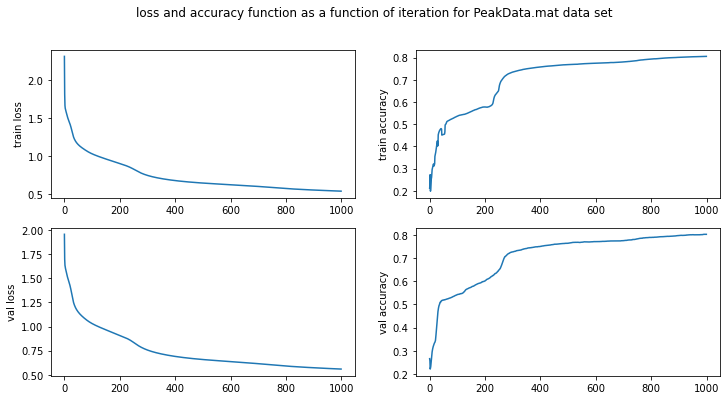

In [108]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 5, activation=softmax()))
loss_train, accuracy_train, loss_val, accuracy_val = SGD(model, X, Y,
                    X_val, Y_val, 1000, 0.01, cross_entropy_loss, 1000)
print('val accuracy : {}'.format(np.max(accuracy_val)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration for PeakData.mat data set')

axs[0][0].plot(loss_train)
axs[0][0].set_ylabel('train loss')
axs[0][1].plot(accuracy_train)
axs[0][1].set_ylabel('train accuracy')
axs[1][0].plot(loss_val)
axs[1][0].set_ylabel('val loss')
axs[1][1].plot(accuracy_val)
axs[1][1].set_ylabel('val accuracy')

plt.show()

<br>
This model reached ~80% accuracy, which is just what we hoped for, we knew that the one layer model wasn't enought and this model confirm that claim.<br>

val accuracy : 0.90304


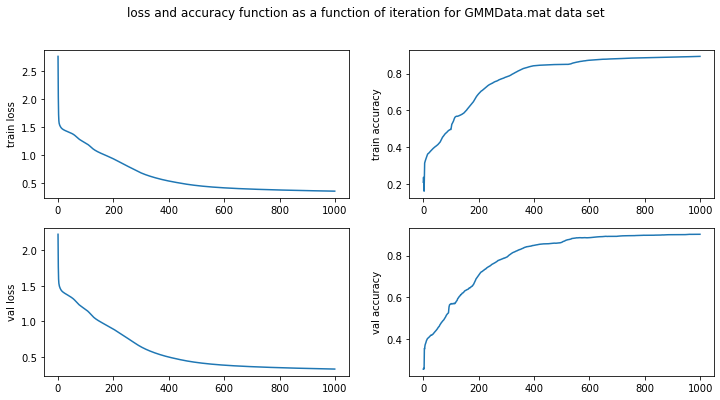

In [110]:
model2 = sequential_model(
        linear_layer(5, 5, activation=tanh()),
        linear_layer(5, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 5, activation=softmax())
)

loss_train, accuracy_train, loss_val, accuracy_val = SGD(model2, X2, Y2,
                    X2_val, Y2_val, 1000, 0.01, cross_entropy_loss, 1000)

print('val accuracy : {}'.format(np.max(accuracy_val)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration for GMMData.mat data set ')

axs[0][0].plot(loss_train)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(accuracy_train)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(loss_val)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(accuracy_val)
axs[1][1].set_ylabel('val accuracy')

plt.show()

Now we even got 90% accuracy on the validation dataset , we can see that we are on the right path.<br><br><br>
The following code will create a grid search which will also optimize the number of layers in the network, starting from 2 to 6 where the layer i will have shape of $ (2^{i+1}*X_{dim}) x (2^i*X_{dim}) $, the last layer will allways have output dimension of 5 but the input dimension will change based on the previos layer.<br>
In this section we won't optimize the number of iterations, we will just assume that after 1000 ephocs the network wont learn anymore.

In [169]:
def model_init(num_layers, dim_in, dim_out):
    return sequential_model(
        *[linear_layer(dim_in * pow(2, i), dim_in * pow(2, i+1),
                           activation=tanh()) for i in range(num_layers - 1)],
        linear_layer(dim_in * pow(2, num_layers - 1), dim_out, activation=softmax())
        )

def nn_grid_search(X, Y, X_val, Y_val, num_layers_values, 
                   learning_rate_values, batch_size_values):
    train_accuracy = []
    val_accuracy = []
    val_loss = []
    train_loss = []
    for learning_rate in learning_rate_values:
            for batch_size in batch_size_values:
                for num_layers in num_layers_values:
                    model = model_init(num_layers, X.shape[0], Y.shape[0])
                    loss_train, accuracy_train, loss_val, accuracy_val = SGD(model, X, 
                                                Y, X_val, Y_val, 1000, learning_rate,
                                                cross_entropy_loss, batch_size)
                    train_accuracy.append(accuracy_train)
                    val_accuracy.append(accuracy_val)
                    train_loss.append(loss_train)
                    val_loss.append(loss_val)
    return train_accuracy, train_loss, val_accuracy, val_loss

In [170]:
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [100, 1000, 2500]
num_layers = [2, 3, 4, 5]

train_accuracy, train_loss, val_accuracy, val_loss = nn_grid_search(X, Y, 
                                                X_val, Y_val, num_layers, 
                                                learning_rates, batch_sizes)

<br><br><br><br><br><br><br><br><br><br><br><br>

the best val accuracy is obtained using learning rate = 0.1, batch size = 2500, number of layers = 4
best accuracy : 0.86496


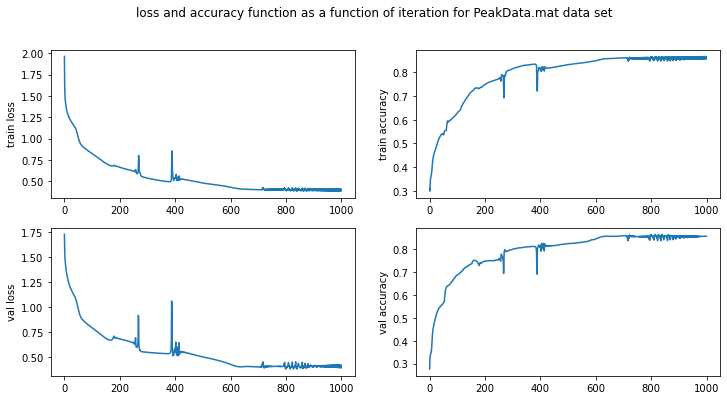

In [171]:
max_values = list(map(lambda x : max(x), val_accuracy))
index = np.argmax(max_values)

print('the best val accuracy is obtained using learning rate = {}, batch size = {}, number of layers = {}'.format( learning_rates[int(index / 12)],  batch_sizes[int(index / 4) % 3], num_layers[index % 4]))
print('best accuracy : {}'.format(np.max(max_values)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration for PeakData.mat data set')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

We got that the best resulst using large learning rate and large batch size, which is smiller to what we got using only 1 layer.<br>
But before we do that, we will plot the model loss,accuracy for both training and validation for batch size 1000 and learning rate 0.01 for diffrent number of layers to see of the model was overfitting or underfitting.<br><br>

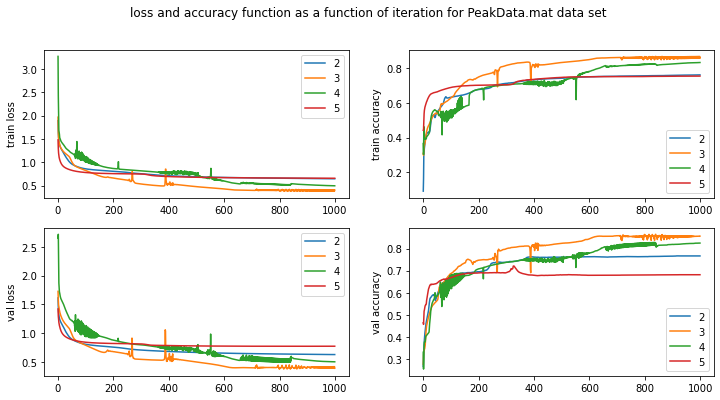

In [172]:
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration for PeakData.mat data set')

axs[0][0].plot(train_loss[index - 1], label='2')
axs[0][0].plot(train_loss[index], label='3')
axs[0][0].plot(train_loss[index + 1], label='4')
axs[0][0].plot(train_loss[index + 2], label='5')
axs[0][0].set_ylabel('train loss')
axs[0][0].legend()

axs[0][1].plot(train_accuracy[index - 1], label='2')
axs[0][1].plot(train_accuracy[index], label='3')
axs[0][1].plot(train_accuracy[index + 1], label='4')
axs[0][1].plot(train_accuracy[index + 2], label='5')
axs[0][1].set_ylabel('train accuracy')
axs[0][1].legend()

axs[1][0].plot(val_loss[index - 1], label='2')
axs[1][0].plot(val_loss[index], label='3')
axs[1][0].plot(val_loss[index + 1], label='4')
axs[1][0].plot(val_loss[index + 2], label='5')
axs[1][0].set_ylabel('val loss')
axs[1][0].legend()

axs[1][1].plot(val_accuracy[index - 1], label='2')
axs[1][1].plot(val_accuracy[index], label='3')
axs[1][1].plot(val_accuracy[index + 1], label='4')
axs[1][1].plot(val_accuracy[index + 2], label='5')
axs[1][1].set_ylabel('val accuracy')
axs[1][1].legend()

plt.show()

<br><br><br>
We can see that the 4 layer model is outpreforming all the other model, and we can also see that the graph have some spikes , probably because the learning rate is very big.<br>
We will now try model with 8 layers to see is preformence using very small batch size and very small learning rate.

val accuracy : 0.24528


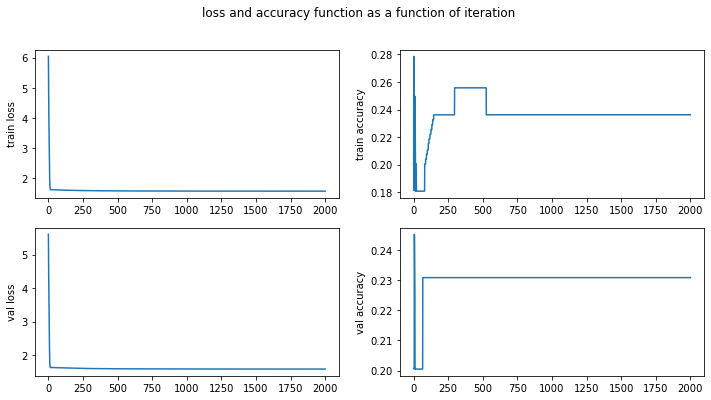

In [173]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 32, activation=tanh()),
        linear_layer(32, 64, activation=tanh()),
        linear_layer(64, 64, activation=tanh()),
        linear_layer(64, 64, activation=tanh()),
        linear_layer(64, 5, activation=softmax())
        )

train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X, Y, 
                    X_val, Y_val, 2000, 0.001, cross_entropy_loss, 500)

print('val accuracy : {}'.format(np.max(val_accuracy)))
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')
axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')
axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')
axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

In class we've learned that a network created from too many layer or with too many variables can create a case of overfitting and though the accuracy of the train data will get better the validation data will not show the same upward trend, or underfitting when the model cannot learn so many parameters from the given dataset(vanshing or exploding gradient), we can see that this is probably the case here, our model doesn't learn anything with all those layers.<br>
Though we've tested more networks with more layers, the best results were provided by a network with only 3 layers as expected from this theory. <br>
Now we will repeat the same process with GMM dataset.

In [123]:
train_accuracy, train_loss, val_accuracy, val_loss = nn_grid_search(X2, Y2, X2_val,
                                    Y2_val, num_layers, learning_rates, batch_sizes)

the best val accuracy is obtained using learning rate = 0.1, batch size = 2500, number of layers = 4
best accuracy : 0.9664


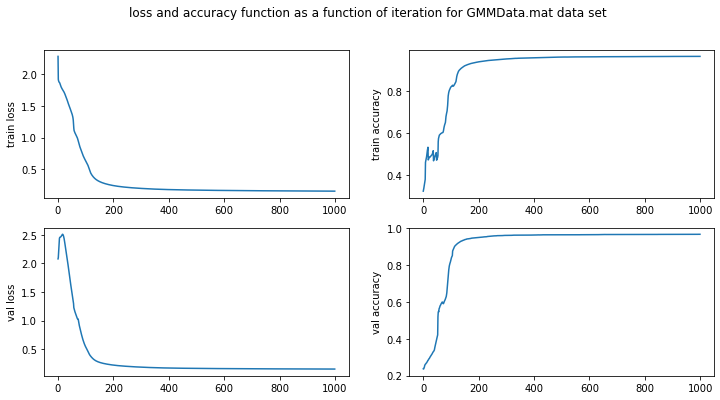

In [126]:
max_values = list(map(lambda x : max(x), val_accuracy))
index = np.argmax(max_values)
print('the best val accuracy is obtained using learning rate = {}, batch size = {}, number of layers = {}'.format( learning_rates[int(index / 12)],  batch_sizes[int(index / 4) % 3], num_layers[index % 4]))
print('best accuracy : {}'.format(np.max(max_values)))
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration for GMMData.mat data set')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')
axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')
axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')
axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

In the GMM dataset, we can see that we reached 96% accuracy using only 2 layers , we can see that the loss converges very fast so we dont need to train the network anymore.<br>
we will plot the model loss,accuracy for both training and validation for batch size 2500 and learning rate 0.1 for diffrent number of layers to see of the model was overfitting or underfitting.

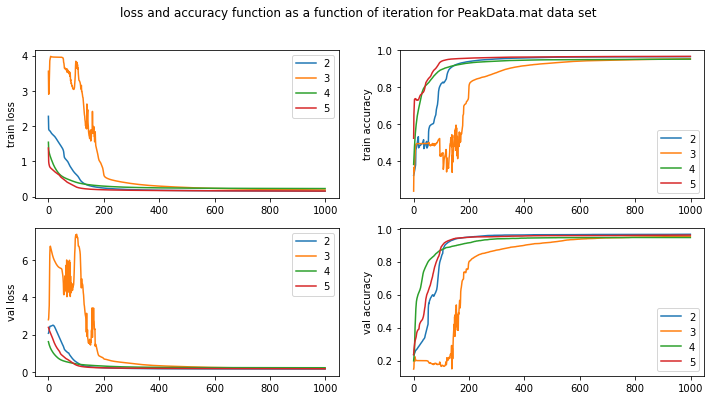

In [133]:
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration for PeakData.mat data set')

axs[0][0].plot(train_loss[index], label='2')
axs[0][0].plot(train_loss[index + 1], label='3')
axs[0][0].plot(train_loss[index + 2], label='4')
axs[0][0].plot(train_loss[index + 3], label='5')
axs[0][0].set_ylabel('train loss')
axs[0][0].legend()
axs[0][1].plot(train_accuracy[index], label='2')
axs[0][1].plot(train_accuracy[index + 1], label='3')
axs[0][1].plot(train_accuracy[index + 2], label='4')
axs[0][1].plot(train_accuracy[index + 3], label='5')
axs[0][1].set_ylabel('train accuracy')
axs[0][1].legend()
axs[1][0].plot(val_loss[index], label='2')
axs[1][0].plot(val_loss[index + 1], label='3')
axs[1][0].plot(val_loss[index + 2], label='4')
axs[1][0].plot(val_loss[index + 3], label='5')
axs[1][0].set_ylabel('val loss')
axs[1][0].legend()
axs[1][1].plot(val_accuracy[index], label='2')
axs[1][1].plot(val_accuracy[index + 1], label='3')
axs[1][1].plot(val_accuracy[index + 2], label='4')
axs[1][1].plot(val_accuracy[index + 3], label='5')
axs[1][1].set_ylabel('val accuracy')
axs[1][1].legend()

plt.show()

The results here are surprising because we can see that almost all the networks reached the same accuracy for the validation and the training, only the network with 3 layers was struggling.<br>
Like we did before, we will now try model with 8 layers to see is preformence, we expect to see underfitted model because of exploding/vanshing gradient problem.

val accuracy : 0.33232


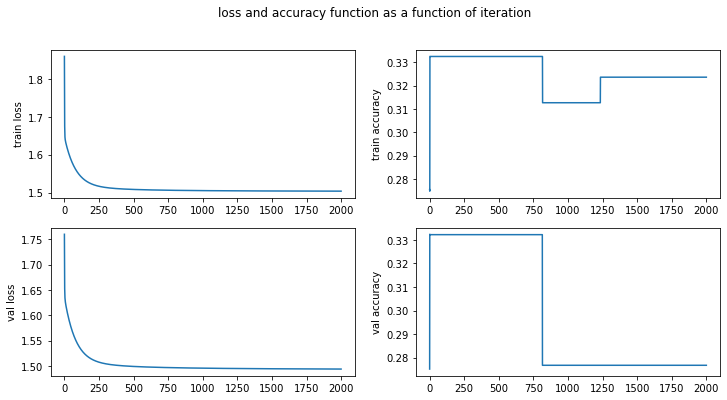

In [175]:
model = sequential_model(
        linear_layer(5, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 32, activation=tanh()),
        linear_layer(32, 64, activation=tanh()),
        linear_layer(64, 64, activation=tanh()),
        linear_layer(64, 64, activation=tanh()),
        linear_layer(64, 64, activation=tanh()),
        linear_layer(64, 5, activation=softmax())
        )
train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X2,
            Y2, X2_val, Y2_val, 2000, 0.001, cross_entropy_loss, 500)
print('val accuracy : {}'.format(np.max(val_accuracy)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')
axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

Agian we see the same problem from before, the network cannot learn at all, the loss converges around 500 iterations and the accuracy doesnt go up.<br>
To conclude, we can see the impact of using hidden layers in our model as the accuracy for both data sets rises for the training data as well as for the validation data. By adding hidden layers we've reached 86% accuracy for PeakData.mat data set and even 96% for GMMData.mat data set.<br>
We've managed to build and train a neural network from scratch.<br>
We didn't have time to try relu activation function instead of tanh, the code of the relu function is in the appendix below.<br>
For full access to the code please visit https://github.com/danikv/DeepLearningEx1 <br>
🥅🏫

In [61]:
# Appendix 
def relu_der (x):
    if x > 0:
        return 1
    else :
        return 0
relu_der2  = np.vectorize(relu_der)

class relu:
    def gradient(self, X, Y, error, W):
        a = relu_der2(Y)
        error2 = error * a
        grad_theta = error2 @ X.T
        grad_b = np.sum(error2, axis=1)
        grad_data = W.T @ error2
        return grad_theta, grad_b, grad_data

        
    def __call__(self, x):
        return (abs(x)+x)/2